In [8]:
using Distributions
using PyCall
using PyPlot
using DelimitedFiles
using LinearAlgebra
using Random
using SparseArrays
using JLD

py"""
import matplotlib.pyplot as plt
plt.rc('pdf', fonttype=42)
plt.rc('font', family='serif', serif=['Arial'])
plt.rcParams['figure.figsize'] = [2,2]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['axes.titlesize'] = 8
"""

# # modifiable parameters - Do we want to keep these or pre-select specific parameters for the workshop?
# lam_list = [0.5, 1.0]
# jj = 2

# L_list = [6.0, 12.0]
# ll = 1

# Lffwd_list = [100, 150, 200, 250, 300, 350, 400]
# oo = 5

# wpffwd_list = [0.0, 1.0, 2.0]
# pp = 1

# fracTrained_list = vcat(collect(0.1:0.1:0.7), 1824/2500)
# qq = 8 # Ntrained = Npyr


include("src_balanced/param.jl");


# 1. Dynamics of excitatory-inhibitory network in the balanced regime

Generate recurrent connections of the balanced network

In [9]:
# Generate the recurrent connections of a balanced network.
# These are static connections and will not be trained.
include("src_balanced/genWeights.jl")
w0Index, w0Weights, nc0 = genWeights(p);

Simulate the activity of balanced network

In [20]:
# Simulate the neural activity of the balanced network
include("src_balanced/runinitial.jl")
times, ns0, uavg, synExc, synInh = runinitial(p, w0Index, w0Weights, nc0);


mean excitatory firing rate: 6.5974 Hz
mean inhibitory firing rate: 11.9692 Hz


Show that the recurrent excitatory and inhibitory inputs to neurons balance each other.

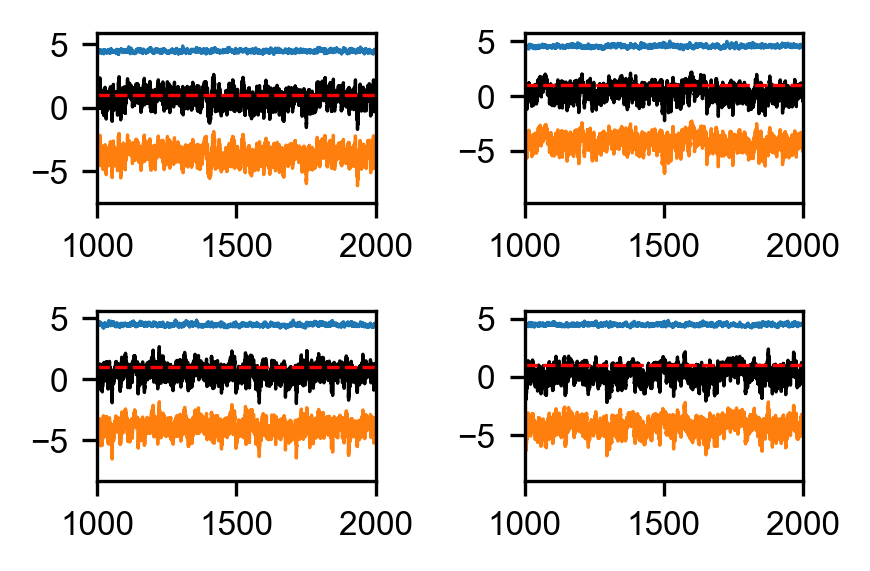

In [31]:
timev = collect(p.dt:p.dt:p.train_duration)
figure(figsize=(3,2))
for ci = 1:4
    subplot(2,2,ci)
    synNet = synExc[ci,:] .+ synInh[ci,:]
    plot(timev, synExc[ci,:], lw=0.8)
    plot(timev, synInh[ci,:], lw=0.8)
    plot(timev, synNet, lw=0.8, c="k")
    axhline(1, color="r", linestyle="--", lw=0.8)
    xlim([1000,2000])
end
tight_layout()
PyPlot.display_figs()

Plot the spike times of neurons

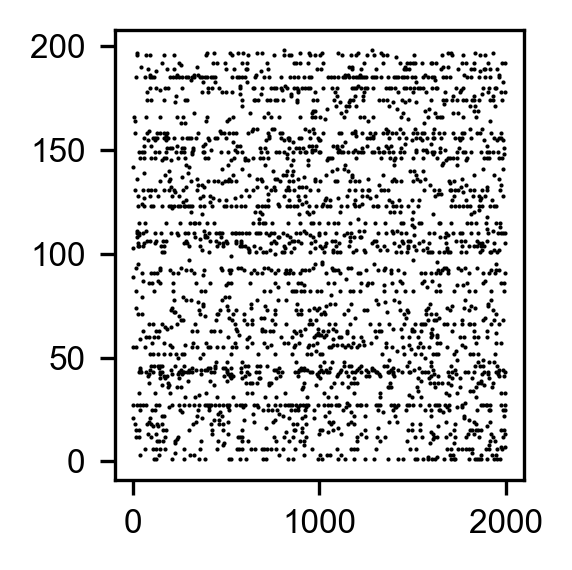

In [15]:
figure(figsize=(2,2))
for i = 1:200
    plot(times[i,1:ns0[i]], i*ones(ns0[i]), marker=".", ms=2, mec="None", c="k", linestyle="")
end
tight_layout()
PyPlot.display_figs()

Show network size or number of recurrent connections can be increased

# 2. Train a subset of neurons in the EI balanced network

## 2.1 Prepare for network training

* ### Subset of neurons to be trained

* ### Sparse plastic synapses to the trained neurons

* ### Stimulus to trigger target activity patterns

* ### Target activity patterns

* ### Feedforward inputs to neurons (if necessary)

Select a fraction of the cells to train

In [7]:
Ntrained = 50
matchedCells = collect(1:Ntrained)
almOrd=matchedCells;

Generate plastic synapses to be trained

In [8]:
# Generate plastic connections to be trained
include("src_balanced/genPlasticWeights.jl")
include("src_balanced/convertWgtIn2Out.jl")
wpWeightFfwd, wpWeightIn, wpWeightOut, 
wpIndexIn, wpIndexOut, wpIndexConvert, 
ncpIn, ncpOut = genPlasticWeights(p, w0Index, nc0, ns0, matchedCells);


Generate target activity patterns

In [15]:
# Generate target data for training
function run_target(p, matchedCells)
    T = p.train_duration #should this be train_duration or train_time?
    t    = collect(dt:20:T);
    u_periodic  = zeros(length(t),p.Ncells);
    for j in matchedCells
        A = 1.0 
        T1 = 1000
        t1 = T1*rand();
        u_periodic[:,j] = A*sin.((t.-t1)*(2*pi/T1)) .+ uavg[j]            
    end
    return u_periodic
end

xtarg = Vector{Array{Float64,2}}()
utarg = run_target(p, matchedCells)
push!(xtarg,utarg);

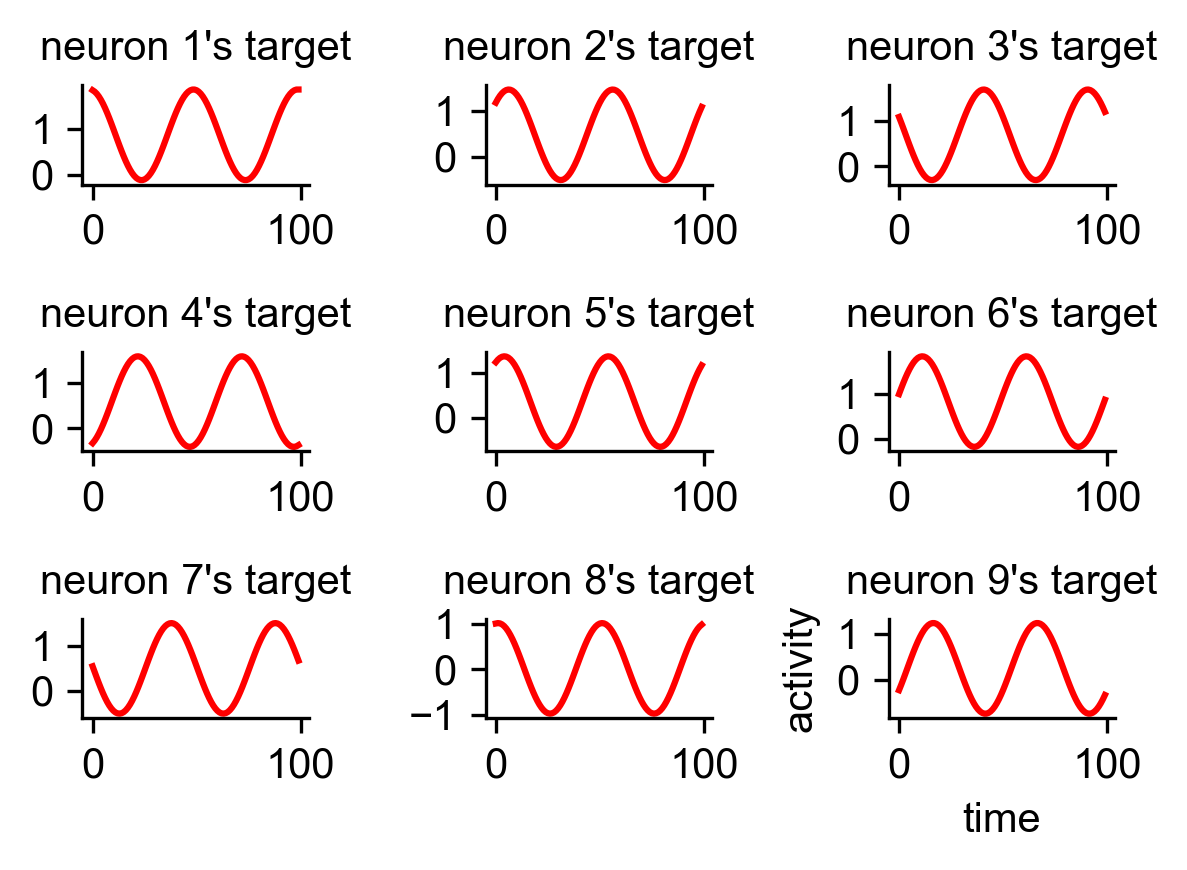

In [18]:
# show target activity patterns
figure(figsize=(4,3))
for ci = 1:9
    ax = subplot(3,3,ci)
    plot(xtarg[1][:,ci], c="r")
    title("neuron $(ci)'s target", fontsize=10)
    ax.spines["right"].set_visible(false)
    ax.spines["top"].set_visible(false)
end
xlabel("time")
ylabel("activity")
tight_layout()
#savefig("figure/target.pdf")
PyPlot.display_figs()

Generate stimulus to trigger target response

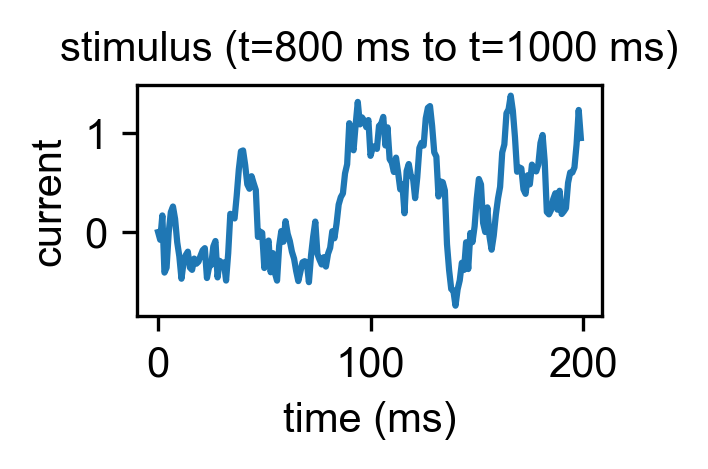

In [14]:
# Generate stimulus to trigger response.
include("src_balanced/genStim.jl")

stim = Vector{Array{Float64,2}}()
stim_val = genStim(p)
push!(stim, stim_val);

figure(figsize=(2,1))
plot(stim[1][1:10:end,500])
xlabel("time (ms)")
ylabel("current")
title("stimulus (t=800 ms to t=1000 ms)")
PyPlot.display_figs()

Generate feedforward inputs to neurons

In [ ]:
# generate feedforward drive
include("src_balanced/genffwdRate.jl")
include("src_balanced/funMovAvg.jl")

ffwdRate_mean = 5.0; # Hz
ffwdRate = Vector{Array{Float64,2}}();
ffwdRate_val = genffwdRate(p, ffwdRate_mean);
push!(ffwdRate, ffwdRate_val);

print(size(ffwdRate[1]));

(20000, 300)

## 2.2 Train a subset of neurons in the balanced network

Train a subset of neurons to follow target activity patterns

In [22]:
#train spatial model
using Statistics
p.nloop=50
p.refrac=0.1

include("src_balanced/runtrain.jl")
include("src_balanced/runperformance.jl")
include("src_balanced/runtest.jl")
include("src_balanced/funRollingAvg.jl")

#define path to data network 

dirNetwork = "src_balanced/data_network/"
mkpath(dirNetwork)

wpWeightIn, wpWeightOut, wpWeightFfwd = runtrain(dirNetwork,p,w0Index,w0Weights,nc0, stim, xtarg,
wpWeightFfwd, wpIndexIn, wpIndexOut, wpIndexConvert, wpWeightIn, wpWeightOut, ncpIn, ncpOut,
almOrd, matchedCells, ffwdRate)


Loop no. 1
elapsed time: 4.117849111557007
Loop no. 2
elapsed time: 4.049506902694702
Loop no. 3
elapsed time: 4.086374998092651
Loop no. 4
elapsed time: 4.101078987121582
Loop no. 5
elapsed time: 4.066722869873047
Loop no. 6
elapsed time: 4.1459269523620605
Loop no. 7
elapsed time: 5.551922082901001
Loop no. 8
elapsed time: 4.26264500617981
Loop no. 9
elapsed time: 4.3924620151519775
Loop no. 10
elapsed time: 4.268836975097656
Loop no. 11
elapsed time: 4.1259801387786865
Loop no. 12
elapsed time: 4.070305109024048
Loop no. 13
elapsed time: 4.091578006744385
Loop no. 14
elapsed time: 4.058633089065552
Loop no. 15
elapsed time: 4.076138973236084
Loop no. 16
elapsed time: 4.118547201156616
Loop no. 17
elapsed time: 4.3354480266571045
Loop no. 18
elapsed time: 4.3446619510650635
Loop no. 19
elapsed time: 4.116233825683594
Loop no. 20
elapsed time: 4.05587911605835
Loop no. 21
elapsed time: 4.116160154342651
Loop no. 22
elapsed time: 4.809948205947876
Loop no. 23
elapsed time: 4.1734127998

([6.141276064367043 5.1458646839572255 … -4.036946968068861 1.4805063601508608; 2.445824316057633 -1.2522803493698786 … 2.825624803505444 1.7876515264923274; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-1.36692371701313 3.858453192348553 … 1.7876515264923274 3.9374088530926197; -5.029541424113668 1.9693358560491632 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [[-0.7825788674862184 -0.1512569930465383 … 0.283801395943311 -0.09943451205961396; -0.5690664566306629 -0.6967860185326656 … 0.11619142314063817 -0.3362304068624931; … ; 0.0 -0.0 … 0.0 -0.0; 0.0 0.0 … 0.0 0.0], [-0.0 -0.0 … 0.0 -0.0; 0.0 0.0 … -0.0 -0.0; … ; -0.0 0.0 … -0.0 0.0; 0.0 -0.0 … 0.0 0.0]])

Show training performance

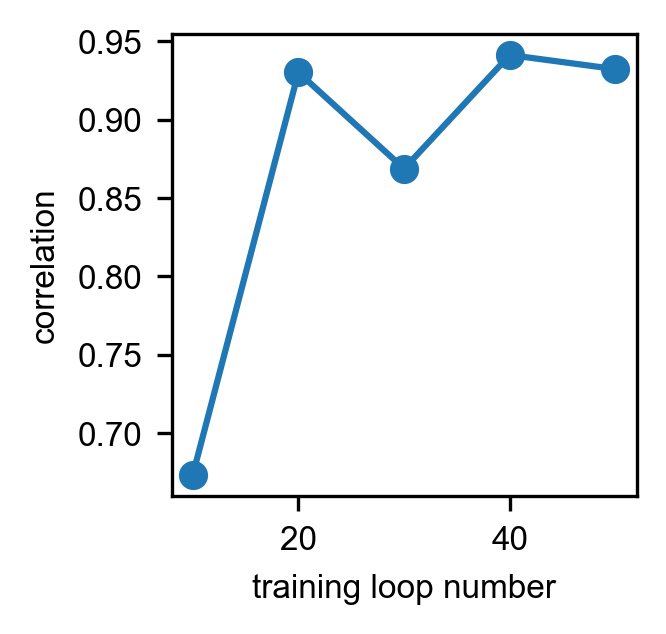

In [27]:
#Check correlation between xtarg and xtotal

iloop=50

loop_numbers = range(10, stop=iloop, step=10)
corr_vals=Float64[]

for l in 10:10:iloop
    filename = dirNetwork * "_performance_R_loop$(l).txt"
    corr = [parse(Float64, item) for item in readlines(filename)][1]
    push!(corr_vals, corr)
end
figure(figsize=(2,2))
plot(loop_numbers, corr_vals,"-o")
ylabel("correlation")
xlabel("training loop number")
PyPlot.display_figs()

## 2.3 Show the activity of trained and untrained neurons

Show that trained neurons' activity follow the target activity patterns

In [28]:
iloop=50
xtotal = load(dirNetwork * "xtotal_$(iloop).jld")["xtotal"]
xebal = load(dirNetwork * "xebal_$(iloop).jld")["xebal"]
xibal = load(dirNetwork * "xibal_$(iloop).jld")["xibal"]
xplastic = load(dirNetwork * "xplastic_$(iloop).jld")["xplastic"]
times = load(dirNetwork * "times_$(iloop).jld")["times"]
ns = load(dirNetwork * "ns_$(iloop).jld")["ns"];

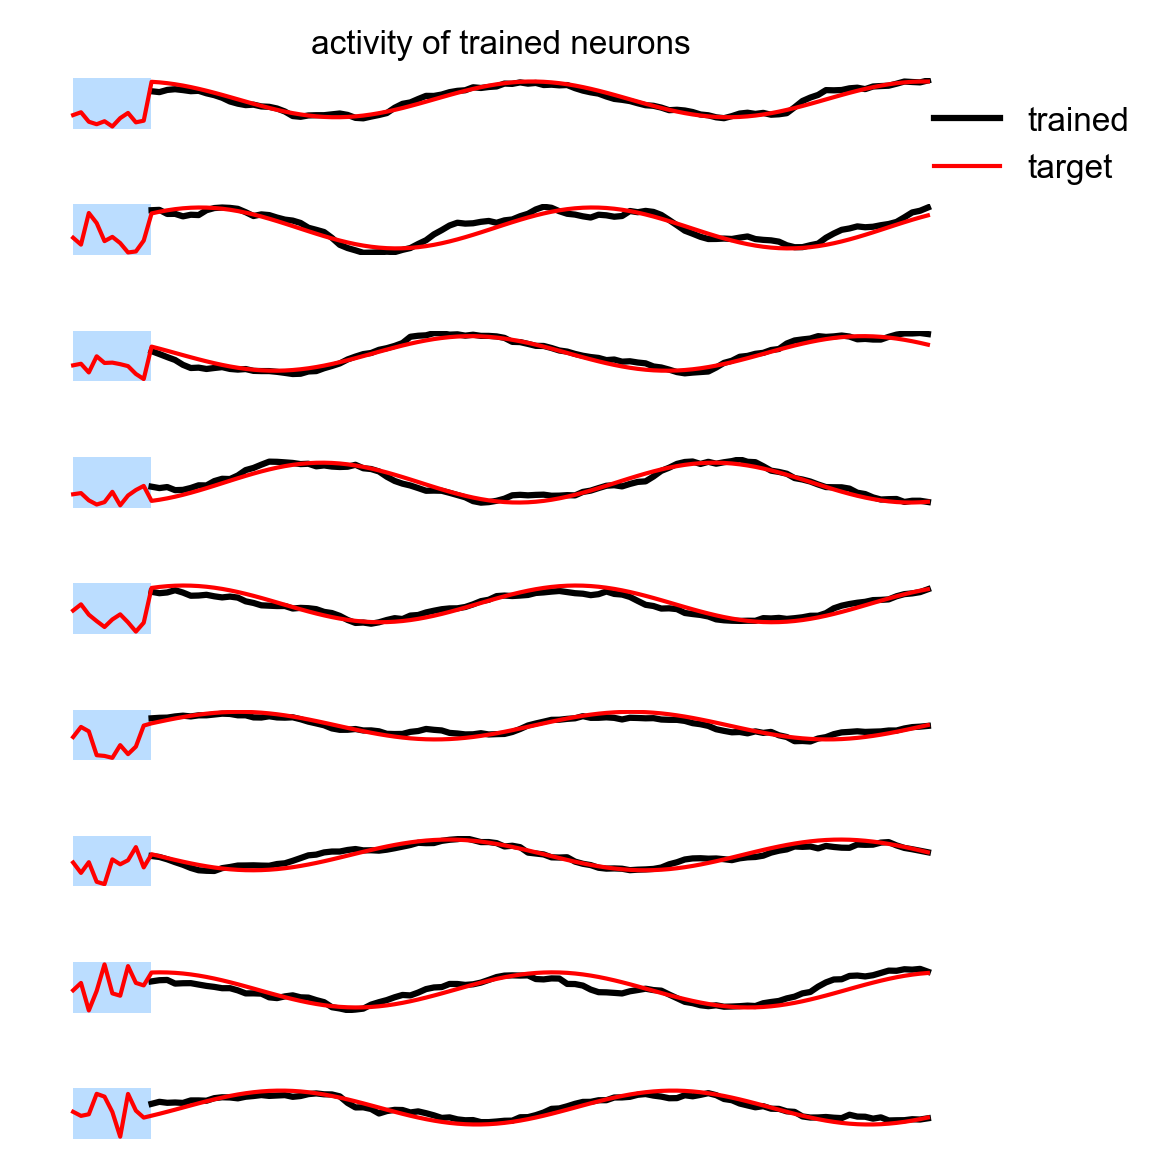

[10010.0, 10210.0, 10410.0, 10610.0, 10810.0, 11010.0, 11210.0, 11410.0, 11610.0, 11810.0, 12010.0, 12210.0, 12410.0, 12610.0, 12810.0, 13010.0, 13210.0, 13410.0, 13610.0, 13810.0, 14010.0, 14210.0, 14410.0, 14610.0, 14810.0, 15010.0, 15210.0, 15410.0, 15610.0, 15810.0, 16010.0, 16210.0, 16410.0, 16610.0, 16810.0, 17010.0, 17210.0, 17410.0, 17610.0, 17810.0, 18010.0, 18210.0, 18410.0, 18610.0, 18810.0, 19010.0, 19210.0, 19410.0, 19610.0, 19810.0, 20010.0, 20210.0, 20410.0, 20610.0, 20810.0, 21010.0, 21210.0, 21410.0, 21610.0, 21810.0, 22010.0, 22210.0, 22410.0, 22610.0, 22810.0, 23010.0, 23210.0, 23410.0, 23610.0, 23810.0, 24010.0, 24210.0, 24410.0, 24610.0, 24810.0, 25010.0, 25210.0, 25410.0, 25610.0, 25810.0, 26010.0, 26210.0, 26410.0, 26610.0, 26810.0, 27010.0, 27210.0, 27410.0, 27610.0, 27810.0, 28010.0, 28210.0, 28410.0, 28610.0, 28810.0, 29010.0, 29210.0, 29410.0, 29610.0, 29810.0]

In [31]:
# compare synaptic activity and its target activity
tvec = collect((p.stim_off+1)/p.dt:p.learn_every/p.dt:p.train_time/p.dt)
ttarg = collect((p.stim_on+1)/p.dt:p.learn_every/p.dt:p.train_time/p.dt) #.+ 2000.0
print(tvec)

figure(figsize=(4,4))
for ci = 1:9
    subplot(9,1,ci)
    axvspan(p.stim_on/p.dt, p.stim_off/p.dt, color="dodgerblue", alpha=0.3, ec="None")
    plot(tvec, xtotal[:,ci].+p.muemax, c="k", label = "trained")
    plot(ttarg, vcat(stim[1][1:Int(p.learn_every/p.dt):end,ci], xtarg[1][:,ci]), c="r", lw=1, label="target")
    annotate("neuron$(ci)", ((p.stim_on/p.dt)-1000,5), fontsize=8)
    
    if ci ==1
        title("activity of trained neurons")
        legend(frameon=false, bbox_to_anchor=(1.2, 1.05),loc="upper right")
    end
    axis("off")
end
tight_layout()
PyPlot.display_figs()

In [32]:
#Get spike rates for each cell in the network 
include("src_balanced/spk2rate.jl")
spikes = spk2rate(p, matchedCells, times, ns);

for ci in matchedCells
    figure()
    plot(spikes[:,ci])
    xlabel("time")
    ylabel("firing rate (spk/s)")

ErrorException: syntax: incomplete: "for" at /Users/kimchm/Documents/GitHub/TutorialCNS2025/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X20sZmlsZQ==.jl:5 requires end